### Задача:
Выполнить предсказание временного ряда. Разделить нужно не смешивая прошлое и будущее. 

Использовать sarima /  Prophet?

docker / собрать контейнер с tf + добавить свои данные

Electric_Production

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 80)

In [71]:
# Прочитаем файл данных
df = pd.read_csv("./Electric_Production.csv", encoding='ANSI', on_bad_lines = 'skip', index_col = "DATE")
df

,IPG2211A2N
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151
...,...
9/1/2017,98.6154
10/1/2017,93.6137
11/1/2017,97.3359


In [8]:
df.dtypes

IPG2211A2N    float64
dtype: object

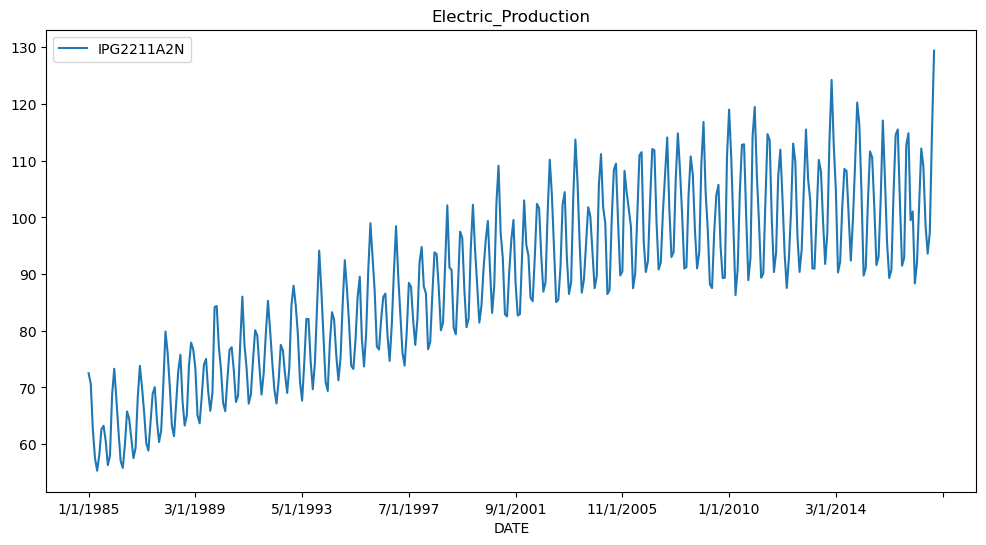

In [47]:
#Визуализация данных
df.plot(figsize = (12, 6))
plt.title("Electric_Production")
plt.show()

In [48]:
# Проверка на пропущенные значения
print(df.isnull().sum())

IPG2211A2N    0
dtype: int64


In [53]:
# Преобразование столбца 'Date' в datetime
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
# Извлечение признаков из даты
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['Is_weekend'] = df.DayOfWeek.isin([5,6])*1
df

,IPG2211A2N,Month,DayOfWeek,Is_weekend
DATE,,,,
1985-01-01,72.5052,1,1,0
1985-01-02,70.6720,1,2,0
1985-01-03,62.4502,1,3,0
1985-01-04,57.4714,1,4,0
1985-01-05,55.3151,1,5,1
...,...,...,...,...
2017-01-09,98.6154,1,0,0
2017-01-10,93.6137,1,1,0
2017-01-11,97.3359,1,2,0


In [148]:
# Функция для разбиения временного ряда на train и test
def train_test_split_time_series(data, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    train = data.iloc[:split_index]  # Обучающая выборка
    test = data.iloc[split_index:]   # Тестовая выборка
    return train, test

In [149]:
# Разбиение временного ряда
train, test = train_test_split_time_series(df, test_size=0.2)

In [96]:
# Функция для проверки на стационарность:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
   
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print(f"{timeseries.name} is stationary")
        return True
    else:
        print(f"{timeseries.name} is not stationary")
        return False

In [54]:
# Код для отрисовки графиков
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        #Расширенный тест единичного корня Дики-Фуллера.
        #Расширенный тест Дики-Фуллера можно использовать для проверки единичного корня в одномерном процессе при наличии последовательной корреляции.


        plt.tight_layout()
    return 

In [150]:
test_stationarity(train.IPG2211A2N)

IPG2211A2N is not stationary


False

Критерий Дики-Фуллера: p=0.411294


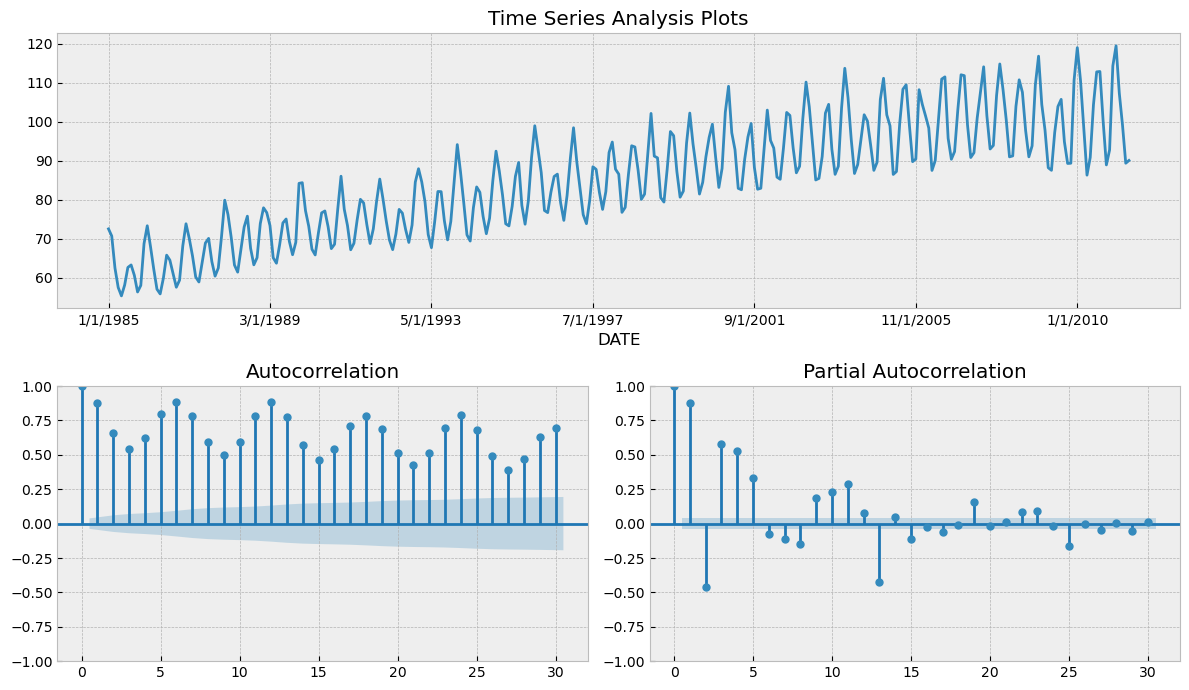

In [151]:
tsplot(train.IPG2211A2N, lags=30)

Критерий Дики-Фуллера: p=0.000000


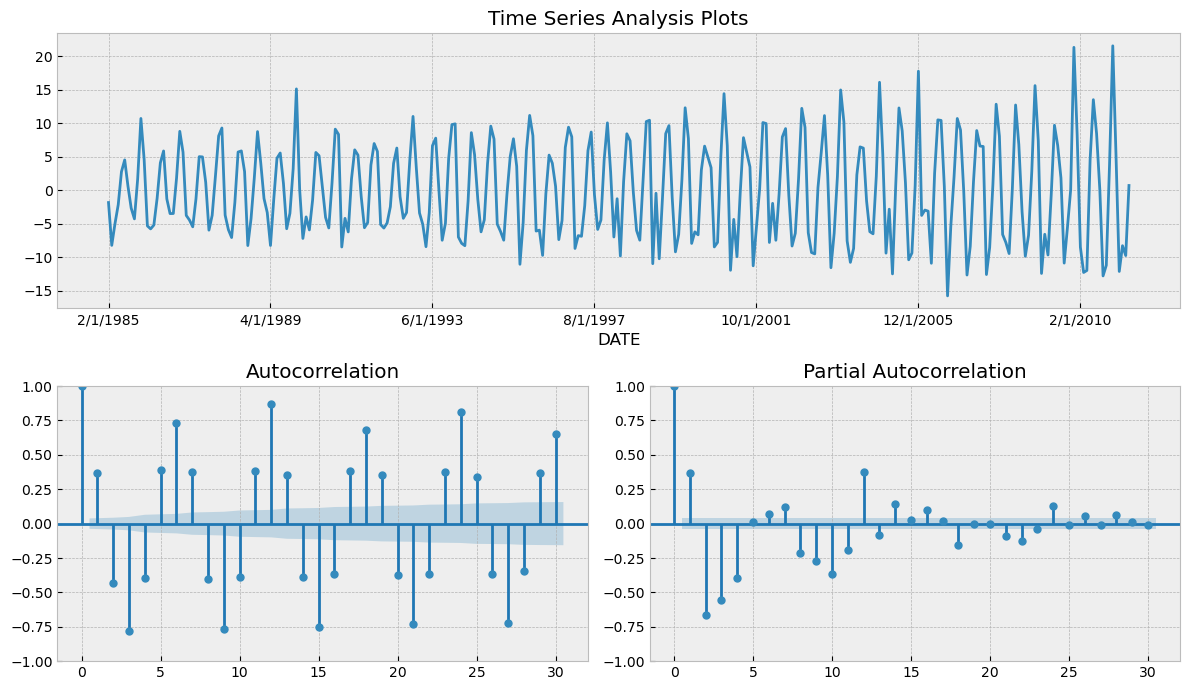

In [152]:
# Исходя из результатов теста, исходный ряд не стационарен. 
# Т.к. гипотеза о наличии единичных корней принимается с малой вероятностью, и, соответственно, ряд не стационарен. 
# Произведем дифференцирование:
diff = train['IPG2211A2N'].diff().dropna()
tsplot(diff, lags=30)

In [153]:
test_stationarity(diff)

IPG2211A2N is stationary


True

In [185]:
# Построение модели Sarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
p = 3
q = 3
d = 1
model = SARIMAX(diff, order=(p,d,q), seasonal_order = (1, 1, 1, 12))
# Обучение модели
model_fit = model.fit(disp=1,solver='powell')
   
fcast = model_fit.get_prediction(start=1, end=len(diff))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed

In [186]:
# Вывод результатов
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           IPG2211A2N   No. Observations:                  316
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -686.001
Date:                              Mon, 17 Feb 2025   AIC                           1390.003
Time:                                      01:18:56   BIC                           1423.426
Sample:                                  02-01-1985   HQIC                          1403.375
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3776      0.084     -4.478      0.000      -0.543      -0.212
ar.L2          0.30

In [187]:
# Прогнозирование на тестовой выборке
forecast_steps = len(test)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean  # Средние значения прогноза
conf_int = forecast.conf_int()  # Доверительные интервалы

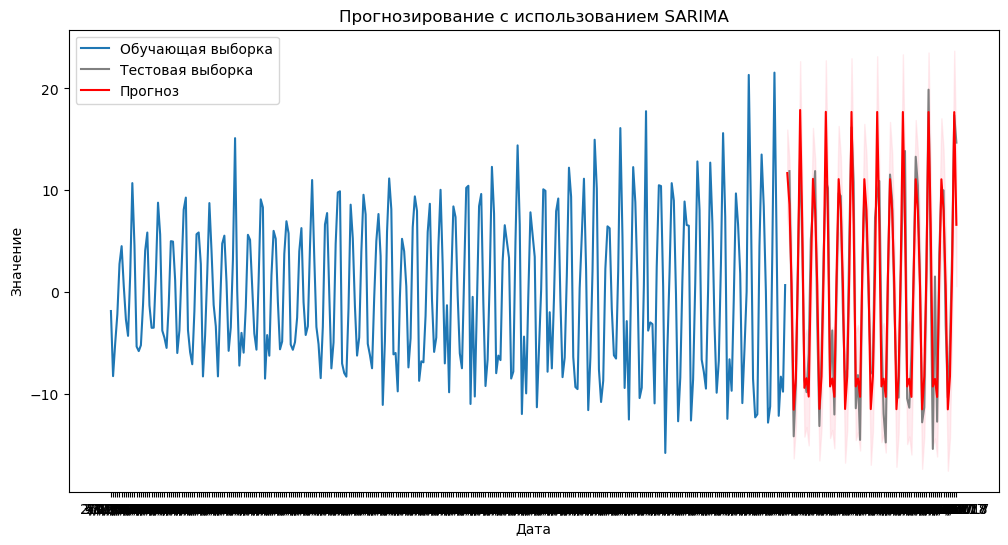

In [188]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(diff.index, diff, label='Обучающая выборка')
plt.plot(test.diff().index, test.diff(), label='Тестовая выборка', color='gray')
plt.plot(test.diff().index, forecast_mean, label='Прогноз', color='red')
plt.fill_between(test.diff().index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Прогнозирование с использованием SARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [224]:
from pmdarima import auto_arima
# Автоматический подбор параметров SARIMA с использованием auto_arima
auto_model = auto_arima(
    diff,
    seasonal=True,  # Включаем сезонность
    m=12,           # Период сезонности
    stepwise=True,  # Пошаговый подбор для ускорения
    trace=True,     # Вывод информации о подборе
    suppress_warnings=True,  # Подавление предупреждений
    error_action="ignore"    # Игнорирование ошибок при подборе
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=1358.425, Time=1.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1536.263, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1474.765, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1400.576, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1534.264, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=1354.923, Time=2.04 sec
 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(2,0,2)(2,1,2)[12] intercept   : AIC=1354.962, Time=2.80 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=1358.790, Time=2.72 sec
 ARIMA(1,0,2)(2,1,1)[12] intercept   : AIC=1354.036, Time=1.52 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=1357.885, Time=1.05 sec
 ARIMA(1,0,2)(2,1,0)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,0,2)(2,1,2)[12] intercept   : 

In [225]:
# Вывод подобранных параметров
print(auto_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  316
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -669.018
Date:                              Mon, 17 Feb 2025   AIC                           1354.036
Time:                                      01:47:30   BIC                           1383.772
Sample:                                  02-01-1985   HQIC                          1365.931
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0050      0.003     -1.940      0.052      -0.010    5.16e-05
ar.L1          0.36

In [226]:
# Прогнозирование на тестовой выборке
forecast_steps = len(test.diff())
forecast = auto_model.predict(n_periods=forecast_steps)

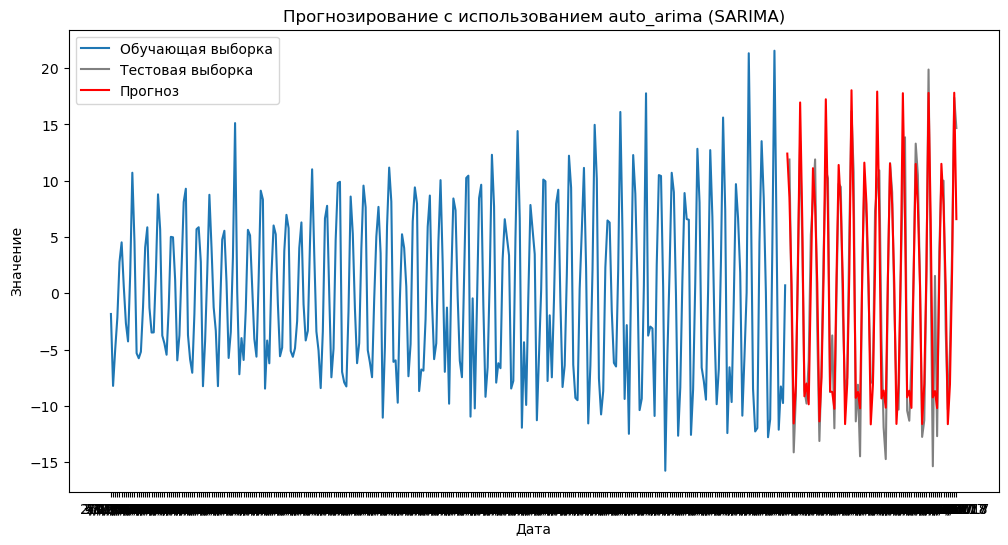

In [227]:
# Визуализация результатов auto_arima
plt.figure(figsize=(12, 6))
plt.plot(diff.index, diff, label='Обучающая выборка')
plt.plot(test.diff().index, test.diff(), label='Тестовая выборка', color='gray')
plt.plot(test.diff().index, forecast, label='Прогноз', color='red')
plt.title('Прогнозирование с использованием auto_arima (SARIMA)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [256]:
# Prophet
from prophet import Prophet
prophet_model = Prophet()

In [257]:
data = train.copy()
data["ds"] = train.index
data["y"] = train.IPG2211A2N
data = data.reset_index()
data = data.drop(columns=['IPG2211A2N', "DATE"])
data

,ds,y
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
312,1/1/2011,119.4880
313,2/1/2011,107.3753
314,3/1/2011,99.1028
315,4/1/2011,89.3583


In [258]:
# Обучение модели
prophet_model.fit(data)

02:07:46 - cmdstanpy - INFO - Chain [1] start processing
02:07:46 - cmdstanpy - INFO - Chain [1] done processing


In [265]:
# Создание фрейма для прогнозирования (на 100 дней вперед)
future = prophet_model.make_future_dataframe(periods=100)

In [263]:
# Прогнозирование
forecast = prophet_model.predict(future)

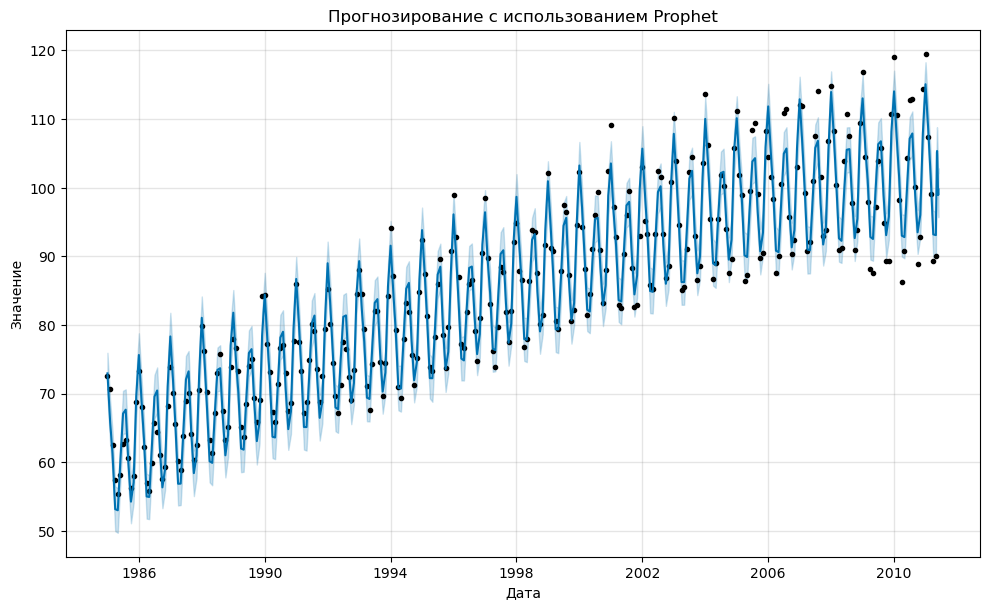

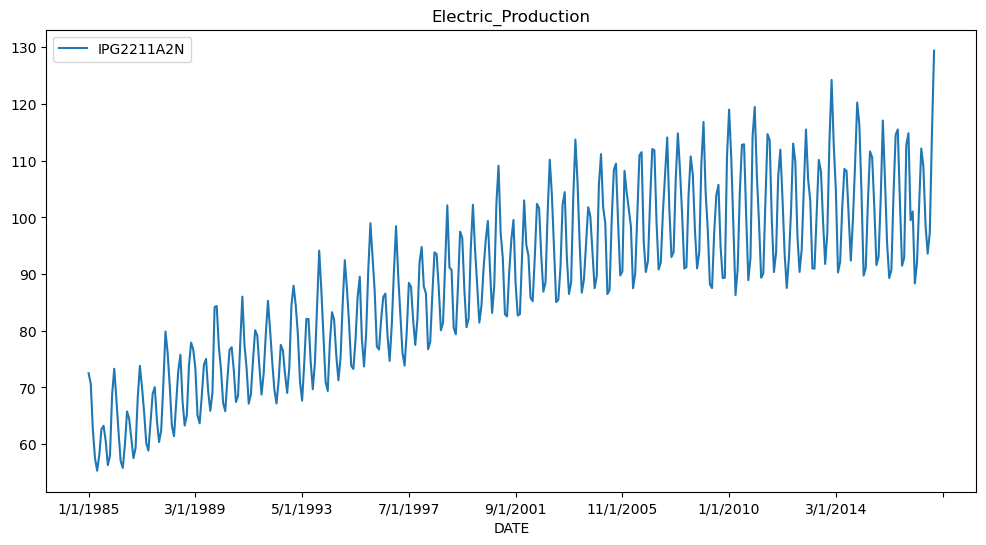

In [281]:
# Визуализация результатов Prophet
prophet_model.plot(forecast)
plt.title('Прогнозирование с использованием Prophet')
plt.xlabel('Дата')
plt.ylabel('Значение')
df.plot(figsize = (12, 6))
plt.title("Electric_Production")
plt.show()

# Вывод:
Стабилизировали данные.

Sarima и auto_sarima показали схожий результат. 

Prophet также дал достаточно точный прогноз.